In [1]:
using RigidBodyDynamics
using ForwardDiff
using Plots
using MeshCatMechanisms

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [2]:
urdf = "doublependulum.urdf"
doublependulum = parse_urdf(Float64,urdf)

Spanning tree:
Vertex: world (root)
  Vertex: base_link, Edge: base_link_to_world
    Vertex: upper_link, Edge: shoulder
      Vertex: lower_link, Edge: elbow
No non-tree joints.

In [3]:
state = MechanismState(doublependulum)
fixedjoint, shoulder, elbow = joints(doublependulum)

3-element Array{RigidBodyDynamics.Joint{Float64,JT} where JT<:RigidBodyDynamics.JointType{Float64},1}:
 base_link_to_world
 shoulder          
 elbow             

In [4]:
# q = configuration(state)
# v = velocity(state)
# u = [0.;0.]
# dt = 0.1
# S = [q;v;u;dt]
# n = 4
# m = 2

In [5]:
function fc(x,u)
    state = MechanismState{eltype(x)}(doublependulum)
    
    # set the state variables:
    set_configuration!(state, x[1:2])
    set_velocity!(state, x[3:4])
    
    # return momentum converted to an `Array` (as this is the format that ForwardDiff expects)
    [x[3];x[4]; Array(mass_matrix(state))\u - Array(mass_matrix(state))\Array(dynamics_bias(state))]
end

function f(x,u,dt)
    return x + fc(x + fc(x,u)*dt/2,u)*dt
end

f (generic function with 1 method)

In [6]:
function fc2(S)
    state = MechanismState{eltype(S)}(doublependulum)
    
    # set the state variables:
    set_configuration!(state, S[1:2])
    set_velocity!(state, S[3:4])
    [S[3];S[4]; Array(mass_matrix(state))\S[5:6] - Array(mass_matrix(state))\Array(dynamics_bias(state)); 0.;0.;0.]
end

function f2(S)
    return S + fc2(S + fc2(S)*S[end]/2)*S[end]
end

Df = S-> ForwardDiff.jacobian(f2, S)

(::#1) (generic function with 1 method)

In [7]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = f(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,Df,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    S = zeros(n,n,N)
    s = zeros(n,N)
    K = zeros(m,n,N)
    l = zeros(m,N)
    C1 = zeros(1,n,N)
    C2 = zeros(1,m,N)
    C3 = zeros(n,n,N)
    C4 = zeros(m,m,N)
    C5 = zeros(m,n,N)
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)
    v1 = 0
    v2 = 0

    mu = 0.
    k = N-1
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        Df_aug = Df([X[:,k];U[:,k];dt])
        A = Df_aug[1:size(X,1),1:size(X,1)]
        B = Df_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        C1[:,:,k] = q' + s[:,k+1]'*A
        C2[:,:,k] = r' + s[:,k+1]'*B
        C3[:,:,k] = Q + A'*S[:,:,k+1]*A
        C4[:,:,k] = R + B'*(S[:,:,k+1] + mu*eye(n))*B
        C5[:,:,k] = B'*(S[:,:,k+1] + mu*eye(n))*A

        # regularization
        if any(x->x < 0, eigvals(C4[:,:,k]))
            mu_reg = mu_reg + 1;
            k = N-1;
        end

        K[:,:,k] = C4[:,:,k]\C5[:,:,k]
        l[:,k] = C4[:,:,k]\C2[:,:,k]'
        s[:,k] = C1[:,:,k] - C2[:,:,k]*K[:,:,k] + l[:,k]'*C4[:,:,k]*K[:,:,k] - l[:,k]'*C5[:,:,k]
        S[:,:,k] = C3[:,:,k] + K[:,:,k]'*C4[:,:,k]*K[:,:,k] - K[:,:,k]'*C5[:,:,k] - C5[:,:,k]'*K[:,:,k]

        # terms for line search
        v1 += l[:,k]'*C2[:,:,k]'
        v2 += l[:,k]'*C4[:,:,k]*l[:,k]
        
        k = k - 1;
    end
    return K, l, S, s, v1, v2
end

function forwardpass(x0,U,f,Q,R,Qf,xf,dt,tf)
    X = rollout(x0,U,f,dt,tf)
    J = cost(X,U,Q,R,Qf,xf)
    return X, J
end

function solve(x0,m,f,Df,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5,c1=0.25,c2=0.75)
    N = convert(Int64,floor(tf/dt))
    U = zeros(m,N-1)
    X = zeros(size(x0,1),N)
    X, J = forwardpass(x0,U,f,Q,R,Qf,xf,dt,tf)
    println("Initial Cost: $J")
    
    for i = 1:iterations
      println("*** Iteration: $i ***")
      K, l, S, s, v1, v2 = backwardpass(X,U,Df,Q,R,Qf,xf)
      X_prev = copy(X)
      J_prev = copy(J)
      U_ = zeros(m,N-1)
      J = Inf
      alpha = 1
      dV = 0
      z = 0
      while J > J_prev || z < c1 || z > c2
          X[:,1] = x0
          for k = 1:N-1
              U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
              X[:,k+1] = f(X[:,k],U_[:,k],dt);
          end

          J = cost(X,U_,Q,R,Qf,xf)
          dV = alpha*v1 + (alpha^2)*v2/2
          z = (J_prev - J)/dV[1,1]
          alpha = alpha/2;
      end

      U = copy(U_);
      println("New cost: $J")
      println("-----")
      println("Expected improvement: $(-dV)")
      println("Actual improvement: $(J - J_prev)")
      println("(z = $z)")

      if abs(J - J_prev) < eps
          println("eps criteria met at iteration: $i")
          println("-----SOLVED-----")
          break
      end

    end
    
    return X, U
end

solve (generic function with 5 methods)

In [8]:
n = 4
m = 2

# initial and goal states
x0 = [0.;0.;0.;0.]
xf = [pi;0.;0.;0.]

set_configuration!(state, x0[1:2])
set_velocity!(state, x0[3:4])

# costs
Q = 1e-5*eye(n)
Qf = 25.*eye(n)
R = 1e-5*eye(m)

# simulation
tf = 1.
dt = 0.01

0.01

Initial Cost: 123.37494046779551
*** Iteration: 1 ***
New cost: 7.996582089074337
-----
Expected improvement: [-366.471]
Actual improvement: -115.37835837872117
(z = 0.31483596980039885)
*** Iteration: 2 ***
New cost: 2.42094753882873
-----
Expected improvement: [-8.22187]
Actual improvement: -5.575634550245607
(z = 0.6781471686581003)
*** Iteration: 3 ***
New cost: 1.2750355001838978
-----
Expected improvement: [-2.82238]
Actual improvement: -1.1459120386448323
(z = 0.4060087322904319)
*** Iteration: 4 ***
New cost: 0.45817949361150734
-----
Expected improvement: [-3.21948]
Actual improvement: -0.8168560065723904
(z = 0.25372323152785997)
*** Iteration: 5 ***
New cost: 0.2384687894256925
-----
Expected improvement: [-0.765566]
Actual improvement: -0.21971070418581484
(z = 0.28699112151536993)
*** Iteration: 6 ***
New cost: 0.21577388107145512
-----
Expected improvement: [-0.0455076]
Actual improvement: -0.022694908354237375
(z = 0.49870617563264014)
*** Iteration: 7 ***
New cost: 0.20

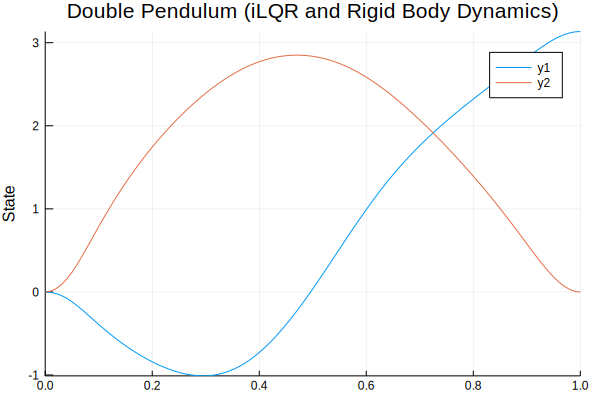

In [42]:
X, U = @time solve(x0,m,f,Df,Q,R,Qf,xf,dt,tf)

P = plot(linspace(0,tf,size(X,2)),X[1,:],title="Double Pendulum (iLQR and Rigid Body Dynamics)")
P = plot!(linspace(0,tf,size(X,2)),X[2,:],ylabel="State")

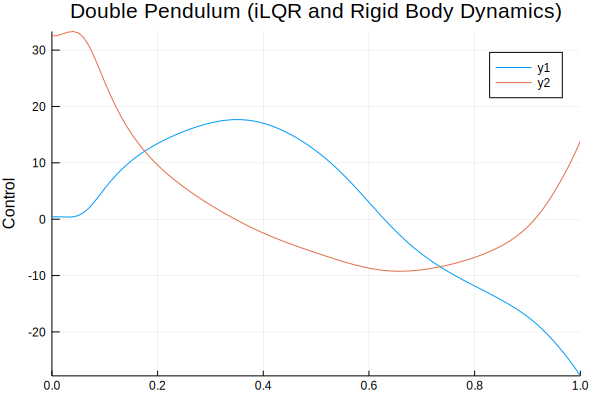

In [43]:
W = plot(linspace(0,tf,size(X,2)),[U[1,1] U[1,:]']',title="Double Pendulum (iLQR and Rigid Body Dynamics)")
W = plot!(linspace(0,tf,size(X,2)),[U[2,1] U[2,:]']',ylabel="Control")

In [10]:
vis = MechanismVisualizer(doublependulum,URDFVisuals(urdf));
IJuliaCell(vis)

WebIO.Scope("scope-cf296670-d100-434b-8d2b-cba4ee458f07", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;pkg/MeshCat/meshcat/dist/main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-0bb7e528-3206-4fff-b8ed-05ca37392856&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-0bb7e528-3206-4fff-b8ed-05ca37392856&quot;,&quot;id&quot;:&quot;ob_02&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_01&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,205,204,204,61,0,0,128,191,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,46,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,98,97,115,101,95,108,105,110,107,47,117,112,112,101,114,95,108,105,110,107,47,108,111,119,101,114,95,108,105,110,107]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_03&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_02&quot;,&quot;va

In [44]:
for i = 1:size(X,2)
    set_configuration!(state, X[1:2,i])
    set_configuration!(vis, configuration(state))
    sleep(0.01)
end